# Deep Learning For Timeseries : Jena Weather Dataset

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided

import IPython
import IPython.display

import os
import datetime
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


## torch device
if torch.cuda.is_available():
    DEVICE = "cuda"
    print("Using Cuda")
    print("Name of the Cuda Device: ", torch.cuda.get_device_name())
    print("GPU Computational Capablity: ", torch.cuda.get_device_capability())
else:
    DEVICE = "cpu"
    print("Using CPU")


Using Cuda
Name of the Cuda Device:  NVIDIA GeForce GTX 1080 Ti
GPU Computational Capablity:  (6, 1)


In [2]:
# Downloading and uncompressing dataset

!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-10-31 19:29:45--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.34.32, 52.216.63.8, 52.216.43.104, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.34.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  2.19MB/s    in 6.2s    

2023-10-31 19:29:52 (2.07 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [25]:
# 데이터 구조 살펴보기

df = pd.read_csv('jena_climate_2009_2016.csv')
df


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [26]:
P = "p (mbar)"
T = "T (degC)"
TPOT = 'Tpot (K)'
TDEW = 'Tdew (degC)'
RH = 'rh (%)'
VPMAX = 'VPmax (mbar)'
VPACT = 'VPact (mbar)'
VPDEF = 'VPdef (mbar)'
SH = 'sh (g/kg)'
H20C = 'H2OC (mmol/mol)'
RHO = 'rho (g/m**3)'
WV = 'wv (m/s)'
MAXWV = 'max. wv (m/s)'
WD = 'wd (deg)'

date_time = pd.to_datetime(
    df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S'
)

df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


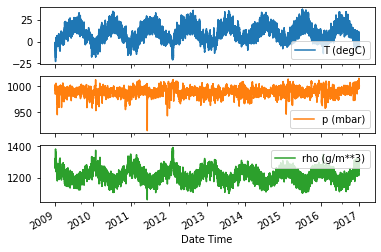

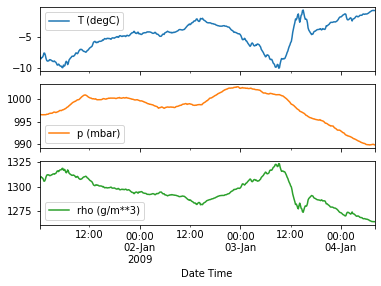

In [27]:
plot_cols = [T, P, RHO]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),420451.0,989.212508,8.359454,913.60,984.20,989.57,994.72,1015.35
T (degC),420451.0,9.448567,8.423685,-23.01,3.36,9.41,15.47,37.28
Tpot (K),420451.0,283.491182,8.504820,250.60,277.43,283.46,289.53,311.34
Tdew (degC),420451.0,4.954011,6.730411,-25.01,0.24,5.21,10.07,23.11
rh (%),420451.0,76.007045,16.477126,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420451.0,13.575089,7.739481,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420451.0,9.532524,4.183895,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420451.0,4.042483,4.897270,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420451.0,6.021630,2.655973,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420451.0,9.638982,4.235130,0.80,6.29,8.96,12.48,28.82


/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


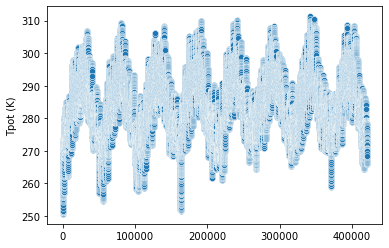

/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


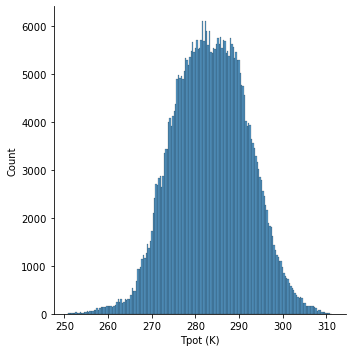

In [29]:
# Plotting the temperature timeseries

sns.scatterplot(x= np.arange(len(df)) ,y=df.iloc[:,2])
plt.show()

sns.displot(df.iloc[:,2])
# 기온의 분포를 확인하는 용도로 사용

/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


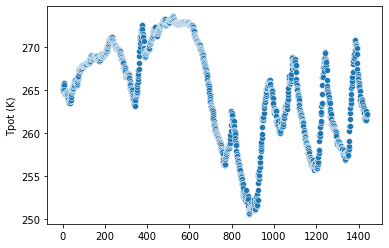

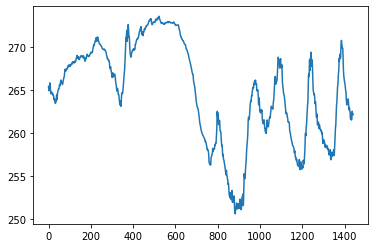

In [30]:
# Plotting the first 10 days of the temperature timeseries

sns.scatterplot(x= np.arange(1440) ,y=df.iloc[:1440,2])
plt.show()

plt.plot(np.arange(1440), df.iloc[:1440,2].to_numpy()) #데이터 프레임 오브젝트로 plt를 이용할 수 없어 numpy로 변환
plt.show()

In [31]:
# Feature engineering

wv = df[WV]
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df[MAXWV]
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

df[WV].min()

# Converting to radians
WX = 'Wx'
WY = 'Wy'
MAXWX = 'Max Wx'
MAXWY = 'Max Wy'

wv = df.pop(WV)
max_wv = df.pop(MAXWV)
# degree to radian
wd_rad = df.pop(WD) * (np.pi / 180)

df[WX] = wv*np.cos(wd_rad)
df[WY] = wv*np.sin(wd_rad)

df[MAXWX] = max_wv * np.cos(wd_rad)
df[MAXWY] = max_wv * np.sin(wd_rad)




In [32]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# new columns
DAYSIN = 'day sin'
DAYCOS = 'day cos'
YEARSIN = 'year sin'
YEARCOS = 'year cos'

day = 24 * 60 * 60
year = (365.2425) * day

df[DAYSIN] = np.sin(timestamp_s * (2 * np.pi / day))
df[DAYCOS] = np.cos(timestamp_s * (2 * np.pi / day))

df[YEARSIN] = np.sin(timestamp_s * (2 * np.pi / year))
df[YEARCOS] = np.cos(timestamp_s * (2 * np.pi / year))

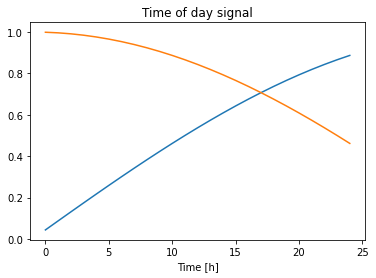

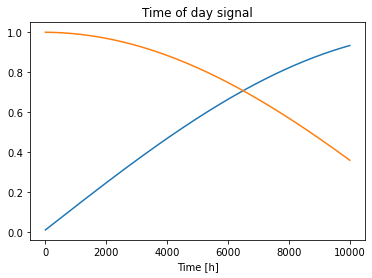

In [33]:
plt.plot(np.array(df[DAYSIN])[:25])
plt.plot(np.array(df[DAYCOS])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

plt.plot(np.array(df[YEARSIN])[:10000])
plt.plot(np.array(df[YEARCOS])[:10000])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

# Data processing

In [34]:
# Splitting the data

col_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)

train_df = df[0:int(n * 0.7)]
val_df = df[int(n * 0.7):int(n * 0.9)]
test_df = df[int(n * 0.9):]

num_features = df.shape[1]

In [35]:
# Normalizing the data

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [36]:
wide_df = pd.DataFrame(np.random.rand(3,4), columns=["A", "B","C","D"])
print("a normal dataframe")
display(wide_df)

# take A to be identifier variable, B C to be values of A but in different timesteps
long_df = wide_df.melt(id_vars=('A'), value_vars=("B", "C"))
print("column B, C melted on A")
display(long_df)
# considers all column to be values in different timesteps
long_df = wide_df.melt()
print("all columns melted on index")
display(long_df)


a normal dataframe


,A,B,C,D
0,0.419104,0.183770,0.866659,0.187469
1,0.011380,0.359346,0.757553,0.024340
2,0.878820,0.643720,0.199259,0.715247


column B, C melted on A


,A,variable,value
0,0.419104,B,0.183770
1,0.011380,B,0.359346
2,0.878820,B,0.643720
3,0.419104,C,0.866659
4,0.011380,C,0.757553
5,0.878820,C,0.199259


all columns melted on index


,variable,value
0,A,0.419104
1,A,0.011380
2,A,0.878820
3,B,0.183770
4,B,0.359346
5,B,0.643720
6,C,0.866659
7,C,0.757553
8,C,0.199259
9,D,0.187469


/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


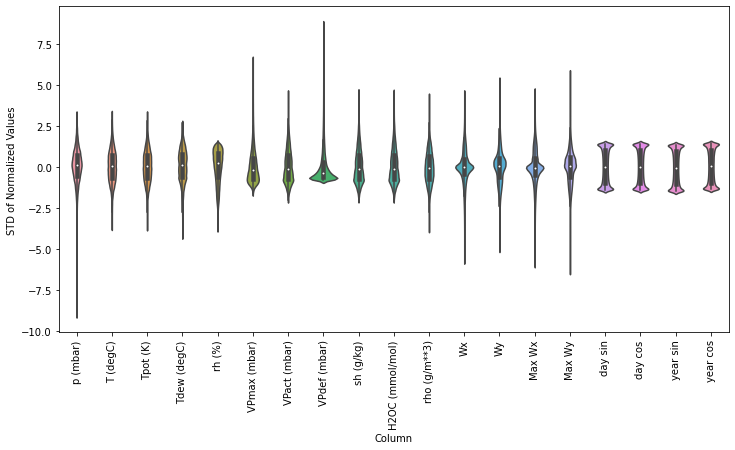

In [37]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
ax.set_ylabel("STD of Normalized Values")
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data Windowing

In [41]:
class TimeSeriesDataset(Dataset):
    """a timeseries dataset with window maker (batch, time, feature)"""
    def __init__(self, df, input_width, label_width, shift=1, step=1, label_cols=None, portion="train"):
        """
        Logical Process for this dataset-
        1. split the 2D data into 3D windowed data
        2. before accessing each window, split them into 
        
        Attributes
        ----------
        df: Dataframe
        label_cols: Iterable of str [Optional]
            contains the column names to use as labels
            
        label_cols_indices: dict [Optional]
            keys are `label_cols` items, values are `0...len(label_cols)-1`
            
        col_indices: dict
            keys are `df` columns, values are `0...len(df.columns)-1`
            
        total_window_size: int
            number of timesteps a single window will take
            
        shift: int
            defines how many timesteps each label will be away from its inputs
            
        step: int
            defines how many timesteps each window will be away from starting of the previous window
        """
        # store raw data in pandas' dataframe
        self.df = df
        
        # work out the label column indices
        self.label_cols = label_cols
        if self.label_cols:
            self.label_cols_indices = {name:i for i, name in enumerate(self.label_cols)}
        
        self.col_indices = {name:i for i, name in enumerate(df.columns)}
        
        # work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.step = step
        
        # for a specific window, input samples
        # and label samples will be taken from
        # this window
        self.total_window_size = input_width + shift
        
        # will slice each window with these
        self.input_slice = slice(0, input_width)
        self.label_slice = slice(self.total_window_size - label_width, None)
        
        # only for example 
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
        
        # actual data which will be used in model
        self.data = self._window_generator(data=df.values,
                                          sequence_length=self.total_window_size,
                                          sequence_stride=self.step)
        
        # to torch.Tensor
        _tmp = [self._split_within_window(sample) for sample in self.data]
        
        self.X = torch.stack([
            torch.tensor(it[0],dtype=torch.double).to(DEVICE) for it in _tmp
        ], dim=0)
        
        self.Y = torch.stack([
            torch.tensor(it[1], dtype=torch.double).to(DEVICE) for it in _tmp
        ], dim=0)
        
        
        # example windows (first three)
        self.example = [(torch.unsqueeze(self.X[i].detach(), 0), 
                         torch.unsqueeze(self.Y[i].detach(), 0)) for i in range(3)]
            
        
    def _window_generator(self, data, sequence_length, sequence_stride=1):
        """
        this is a stripped down version of https://github.com/keras-team/keras/blob/master/keras/preprocessing/timeseries.py
        
        Parameters
        ----------
        data: ndarray.
            containing consecutive data points (timesteps). axis 0 (row) is expected to be the time dimension.
            
        sequence_length: int
            length of the output sequences (number of timesteps in a single window)
            
        sequence_stride: int
            period between successive output sequences. For stride `s`, output samples 
            would start at index `data[i]`, `data[i+s]`, `data[i + 2 * s]`, etc
            
        Returns
        -------
        sequences: ndarray
            this is window collections where each window has shape (timesteps, features)
        """
        if sequence_length <= 0:
            raise ValueError(f"validation failed for `sequence_length` {sequence_length}. Each window must contain at least 1 sample.")
        if sequence_stride <= 0:
            raise ValueError(f'`sequence_stride` must be higher than 0. Received: '
                     f'sequence_stride={sequence_stride}')
        if sequence_stride >= len(data):
            raise ValueError(f'`sequence_stride` must be lower than the length of the '
                     f'data. Received: sequence_stride={sequence_stride}, for '
                     f'data of length {len(data)}')
        # (number of windows, timesteps in each window, features)
        output_shape = (int(np.ceil((data.shape[0]-sequence_length) / sequence_stride)),
                        sequence_length,
                        data.shape[1])
        
        # np.stride are distance between consecutive items in memory
        strides = (data.strides[0] * sequence_stride, ) + data.strides
        to_return = as_strided(data, output_shape, strides, writeable=False).copy()
        
        # make writeable
        to_return.flags["WRITEABLE"] = True
        return to_return
    
    
    
    def _split_within_window(self, sample):
        """
        splits a winodw into inputs and labels
        
        
        """
        inputs = sample[self.input_slice, :]
        labels = sample[self.label_slice, :]
        
        if self.label_cols is not None:
            labels = np.stack(
                [labels[:, self.col_indices[name]] for name in self.label_cols],
                axis=-1)

        return inputs, labels
    
    
    def plot(self, model=None, label_col_no=0, max_subplots=3):
        """
        plot each examples timesteps. if model is provided, plot the predictions too.

        Parameters
        ----------
        model: nn.Module
        label_col_no: int
            determines which column from output cols to plot 
            and determines respective input column from df.columns to plot

        max_subplots: int
            determines how many subplots should there be.
        """
        plt.figure(figsize=(12, 8))
        print(model)

        # split inputs, labels
        inputs = [it[0] for it in self.example]
        labels = [it[1] for it in self.example]

        # find which column from df.columns will be plotted
        try:
            print(self.label_cols_indices)
            # inputs and labels do not have same features
            input_feature_idx = self.col_indices[self.label_cols[label_col_no]]
        except AttributeError:
            # both inputs and labels contain all features
            input_feature_idx = label_col_no


        # number of inputs vs max_subplots
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)

            # y-axis title 
            plt.ylabel(f'{self.label_cols[label_col_no]} (normalized)')

            # timestep vs inputs
            plt.plot(self.input_indices, torch.flatten(inputs[n][:, :, input_feature_idx]).cpu(),
                     label='inputs', marker='.', zorder=-10)

            # plot the timesteps vs outputs
            plt.scatter(self.label_indices, torch.flatten(labels[n][:, :, label_col_no]).cpu(),
                        edgecolors='k', label='labels', c='#2ca02c', s=64)

            # plot prediction when model is provided
            if model:
                model.eval()
                # nth example
                predictions = model(inputs[n])
                predictions = predictions.detach()

                # plot the timestep vs predicted output
                plt.scatter(self.label_indices, torch.flatten(predictions[:, :, label_col_no]).cpu(),
                          marker='X', edgecolors='k', label='predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    
    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        # must return 3D
        inputs =self.X[idx]
        labels = self.Y[idx]
        
        # set specific shape (window, time, feature)
#         inputs = torch.reshape(inputs, (-1, self.input_width, inputs.shape[-1]))
#         labels = torch.reshape(labels, (-1, self.label_width, labels.shape[-1]))
        
        return inputs, labels
        
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_cols}'])

In [42]:
tsd = TimeSeriesDataset(df=train_df,
                       input_width=5,
                       label_width=2,
                       shift=2,
                        step=2,
                       label_cols=[T, RHO])
print(tsd)

Total window size: 7
Input indices: [0 1 2 3 4]
Label indices: [5 6]
Label column name(s): ['T (degC)', 'rho (g/m**3)']


In [43]:
tsd.input_indices, tsd.example[0][0].shape, tsd.example[0][0][:, :, 0].shape

(array([0, 1, 2, 3, 4]), torch.Size([1, 5, 19]), torch.Size([1, 5]))

None
{'T (degC)': 0, 'rho (g/m**3)': 1}


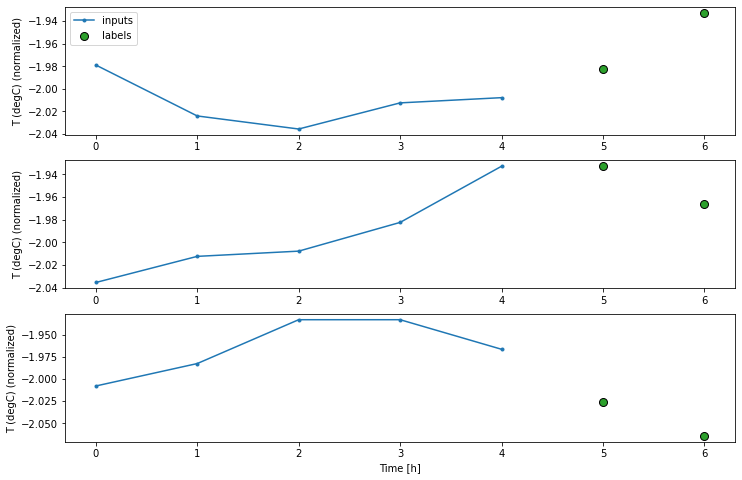

In [44]:
tsd.plot()

In [45]:
# Training Utilities

class History:
    def __init__(self, model):
        self.model_info = str(model)
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_loss = []
        self.val_loss = []
        
    def plot(self, figsize=(10,5), xlabel="Epoch", ylabel="loss"):
        fig, ax = plt.subplots(figsize=figsize)
        if len(self.train_loss) > 0:
            ax.plot(range(len(self.train_loss)), self.train_loss, label='train_loss')
            
        if len(self.val_loss) > 0:
            ax.plot(range(len(self.val_loss)), self.val_loss, label='val_loss')
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend()
        
        plt.show()
        
# settings
val_performance = {}
performance = {}
lr = 0.001
MAX_EPOCH = 20

# utility methods for models
def get_train_test_val(input_width=1,
                       label_width=1,
                       shift=1,
                        step=1,
                       label_cols=[T]):
    train_ds = TimeSeriesDataset(df=train_df,
                        input_width=input_width,
                       label_width=label_width,
                       shift=shift,
                        step=step,
                       label_cols=[T])
    
    test_ds = TimeSeriesDataset(df=test_df,
                        input_width=input_width,
                       label_width=label_width,
                       shift=shift,
                        step=step,
                       label_cols=[T])
    val_ds = TimeSeriesDataset(df=val_df,
                        input_width=input_width,
                       label_width=label_width,
                       shift=shift,
                        step=step,
                       label_cols=[T])
    
    
    return train_ds, test_ds, val_ds


def get_data(train_ds, valid_ds, bs=32, collate_fn=None):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn, drop_last=True),
        DataLoader(valid_ds, batch_size=bs * 2, collate_fn=collate_fn, drop_last=True),
    )

def collate_fn_custom(data):
    """
       data: a list.
            items of the list are the same format as what `Dataset` class's `__getitem__` returns
    """
    # put all x in (batch, time, feature),  y in (batch, time, label)
    inputs = torch.stack([d[0][0] for d in data], dim=0)
    labels = torch.stack([d[1][0] for d in data], dim=0)
    return inputs, labels
    

def custom_mse(predicted, target):
    _loss = torch.mean((predicted - target)**2)
    return _loss

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, verbose=False):
    history = History(model)
    
    for epoch in range(epochs):
        print(f"[Epoch {epoch}/{epochs}]\n", "-"*20)
        
        train_losses = []
        model.train()
        
        for batch, data in enumerate(train_dl):
            xb, yb = data
            
            # gradients on each variable accumulate, so reset them to 0
            opt.zero_grad()
            outputs = model(xb)
            loss = loss_func(outputs, yb)
            loss.backward()
            opt.step()
            
            if batch%100==0:
                train_losses.append(loss.item())
                if verbose:
                    print(f"batch {batch}/{len(train_dl)} - training loss {loss}")
        
        # validate after each epoch
        val_losses = validate(model, loss_func, valid_dl)
        avg_val_loss = np.mean(val_losses)
        avg_train_loss = np.mean(train_losses)
        print(f"\n mean training loss {avg_train_loss}\n\r mean validation loss {avg_val_loss}")
        
        history.train_loss.append(avg_train_loss)
        history.val_loss.append(avg_val_loss)
        
    return history
        

def validate(model, loss_func, valid_dl):
    losses = []
    model.eval()
    for batch, data in enumerate(valid_dl):
        xb, yb = data

        # gradients on each variable accumulate, so reset them to 0
        outputs = model(xb)
        loss = loss_func(outputs, yb)
        
        if batch % 100==0:
            losses.append(loss.item())
    return losses

# single step model

In [46]:
single_step_train = TimeSeriesDataset(df=train_df,
                       input_width=1,
                       label_width=1,
                       shift=1,
                        step=1,
                       label_cols=[T])

single_step_val = TimeSeriesDataset(df=val_df,
                       input_width=1,
                       label_width=1,
                       shift=1,
                        step=1,
                       label_cols=[T])
single_step_test = TimeSeriesDataset(df=test_df,
                       input_width=1,
                       label_width=1,
                       shift=1,
                        step=1,
                       label_cols=[T])
single_step_val

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [47]:
single_step_train.example[0][0].shape,single_step_train.example[0][1].shape,

(torch.Size([1, 1, 19]), torch.Size([1, 1, 1]))

# Baseline Model

In [48]:
class Baseline(nn.Module):
    """returns the same data"""
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def forward(self, xb):
        if self.label_index is None:
            return xb
        else:
            return xb[:, self.label_index]
        
baseline_model = Baseline(label_index=[single_step_train.col_indices[
    single_step_train.label_cols[0]
]])
# opt = torch.optim.SGD(baseline_model.parameters(), lr=lr)
opt = None
loss_fn = nn.MSELoss()
train_dl, valid_dl = get_data(single_step_train, single_step_val, bs=16, collate_fn=collate_fn_custom)

# epochs, model, loss_func, opt, train_dl, valid_dl
# fit(1, baseline_model, loss_fn, opt, train_dl)
hist = validate(baseline_model, loss_fn, valid_dl)

wide_step_train, wide_step_test, wide_step_val = get_train_test_val(
                        input_width=24,
                       label_width=24,
                       shift=1,
                        step=1,
                       label_cols=[T])
wide_step_train

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

None
{'T (degC)': 0}


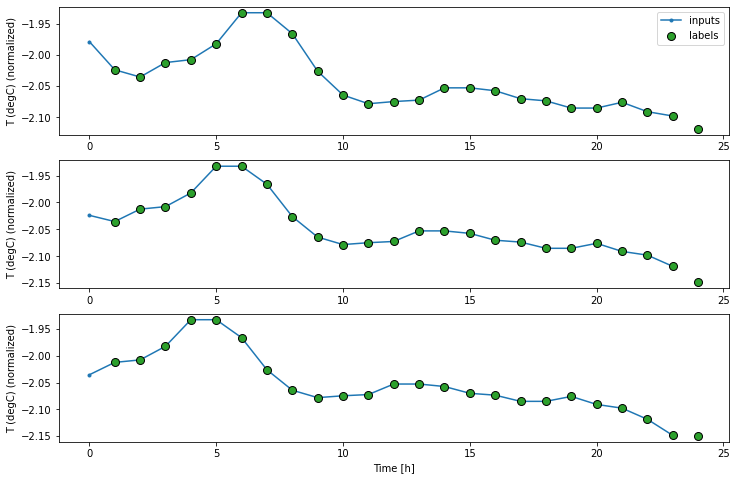

In [49]:
wide_step_train.plot()

In [50]:
train_dl, valid_dl = get_data(wide_step_train, wide_step_val, bs=16, collate_fn=collate_fn_custom)

# epochs, model, loss_func, opt, train_dl, valid_dl
# fit(1, baseline_model, loss, opt, train_dl, valid_dl)
_ = validate(baseline_model, loss_fn, valid_dl)

# Linear Model

In [51]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        # in 19 feats, out 1 label
        self.linear = nn.Linear(19, 1).double()
        
    def forward(self, xb):
        return self.linear(xb)
    
linear_model = LinearModel()
linear_model.to(DEVICE)
opt = torch.optim.Adam(linear_model.parameters(), lr=lr)
train_dl, valid_dl = get_data(single_step_train, single_step_val, bs=32)

# epochs, model, loss_func, opt, train_dl, valid_dl
history = fit(MAX_EPOCH, linear_model, loss_fn, opt, train_dl, valid_dl, verbose=False)

[Epoch 0/20]
 --------------------

 mean training loss 0.017814641955037135
 mean validation loss 0.0108372483806319
[Epoch 1/20]
 --------------------

 mean training loss 0.002162920317361652
 mean validation loss 0.0013159079562717279
[Epoch 2/20]
 --------------------

 mean training loss 0.0007072024228774981
 mean validation loss 0.0014209424809335184
[Epoch 3/20]
 --------------------

 mean training loss 0.0006685838231784909
 mean validation loss 0.0016039486049746377
[Epoch 4/20]
 --------------------

 mean training loss 0.0006975239219303117
 mean validation loss 0.0017268747268825368
[Epoch 5/20]
 --------------------

 mean training loss 0.0007270798952768297
 mean validation loss 0.0017763172750465965
[Epoch 6/20]
 --------------------

 mean training loss 0.0007444727940018672
 mean validation loss 0.001790926988625596
[Epoch 7/20]
 --------------------

 mean training loss 0.0007531464740957677
 mean validation loss 0.0017944358281964904
[Epoch 8/20]
 ----------------

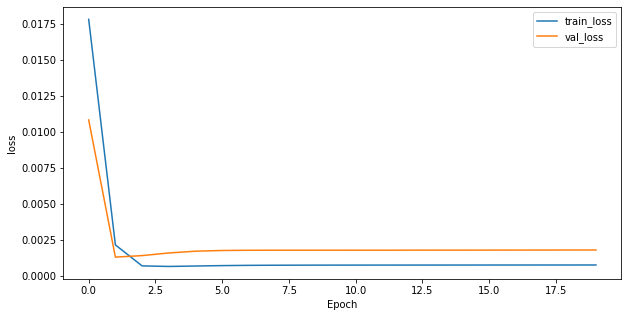

In [52]:
history.plot()

# Dense Model

[Epoch 0/10]
 --------------------

 mean training loss 0.08748137833466989
 mean validation loss 0.010395535225534002
[Epoch 1/10]
 --------------------

 mean training loss 0.0026863593098847374
 mean validation loss 0.007513582096566803
[Epoch 2/10]
 --------------------

 mean training loss 0.0020802668494515225
 mean validation loss 0.005706754685199969
[Epoch 3/10]
 --------------------

 mean training loss 0.001771107600693393
 mean validation loss 0.004205980422929451
[Epoch 4/10]
 --------------------

 mean training loss 0.0013198539420178072
 mean validation loss 0.0031390985584779135
[Epoch 5/10]
 --------------------

 mean training loss 0.0013244087245504663
 mean validation loss 0.002399866383413935
[Epoch 6/10]
 --------------------

 mean training loss 0.001181787936356932
 mean validation loss 0.0022477097324484175
[Epoch 7/10]
 --------------------

 mean training loss 0.0010647339245877412
 mean validation loss 0.0019864517267667516
[Epoch 8/10]
 -------------------

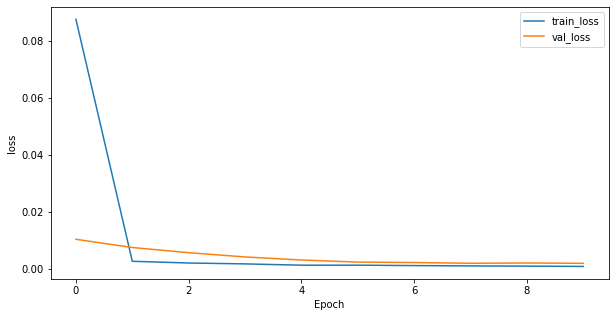

In [53]:
class DenseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(19, 64).double()
        self.linear2 = nn.Linear(64,64).double()
        self.linear3 = nn.Linear(64,1).double()
        
        self.linear = nn.Linear(19,1).double()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        
        return x
    
dense_model = DenseModel()
dense_model.to(DEVICE)
opt = torch.optim.Adam(dense_model.parameters(), lr=0.001)
train_dl, valid_dl = get_data(train_ds=wide_step_train, valid_ds=wide_step_val, bs=64)
loss_fn = nn.MSELoss()

# epochs, model, loss_func, opt, train_dl, valid_dl
history = fit(10, dense_model, loss_fn, opt, train_dl, valid_dl)
history.plot()

DenseModel(
  (linear1): Linear(in_features=19, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
  (linear): Linear(in_features=19, out_features=1, bias=True)
  (relu): ReLU()
)
{'T (degC)': 0}


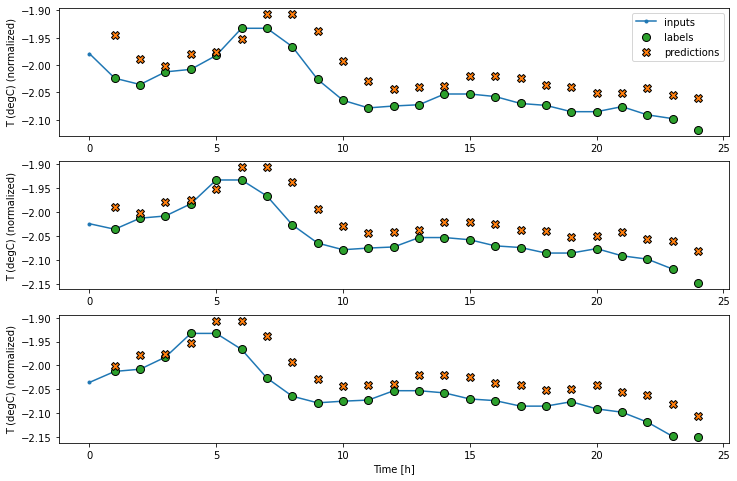

In [54]:
wide_step_train.plot(dense_model)

# Multi -step Dense Model

In [55]:
CONV_WIDTH = 3
conv_step_train = TimeSeriesDataset(df=train_df,
                                input_width=CONV_WIDTH,
                               label_width=1,
                               shift=1,
                               step=1,
                               label_cols=[T])

conv_step_val = TimeSeriesDataset(df=val_df,
                                input_width=CONV_WIDTH,
                               label_width=1,
                               shift=1,
                               step=1,
                               label_cols=[T])


conv_step_train

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

None
{'T (degC)': 0}


(torch.Size([1, 3, 19]), torch.Size([1, 1, 1]))

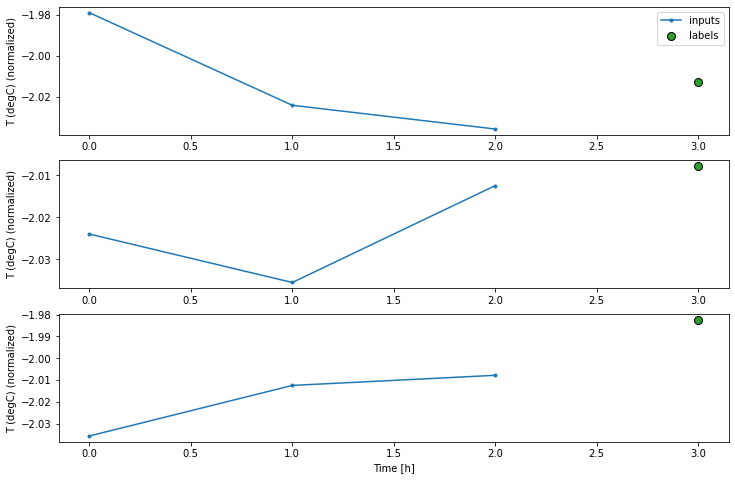

In [56]:
conv_step_train.plot()
conv_step_train.example[0][0].shape, conv_step_train.example[0][1].shape

input shape:  torch.Size([1, 3, 19])
output shape:  torch.Size([1, 1, 1])
[Epoch 0/10]
 --------------------

 mean training loss 0.045913181388303095
 mean validation loss 0.006517046389190602
[Epoch 1/10]
 --------------------

 mean training loss 0.004983854789903673
 mean validation loss 0.005336440594248976
[Epoch 2/10]
 --------------------

 mean training loss 0.003543711978478396
 mean validation loss 0.0029136691317084235
[Epoch 3/10]
 --------------------

 mean training loss 0.0019388198105865714
 mean validation loss 0.003193614618558026
[Epoch 4/10]
 --------------------

 mean training loss 0.0015813905902443694
 mean validation loss 0.002470895596266288
[Epoch 5/10]
 --------------------

 mean training loss 0.0014475863326778575
 mean validation loss 0.001715877846041555
[Epoch 6/10]
 --------------------

 mean training loss 0.001209546463499255
 mean validation loss 0.0014589502971688012
[Epoch 7/10]
 --------------------

 mean training loss 0.0011725074045105133
 me

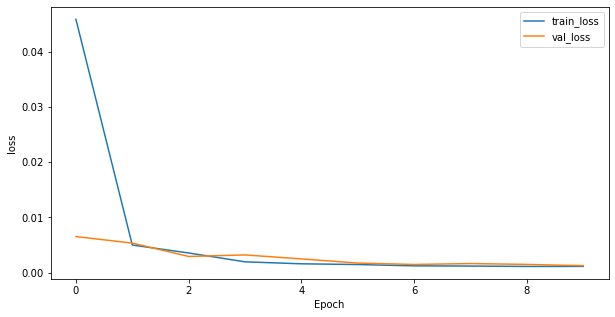

In [57]:
class MultiStepDense(nn.Module):
    def __init__(self, n_features=19, n_timesteps=3):
        super().__init__()
        self.relu = nn.ReLU()
        # shape: (time, features) => (time * features, )
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1).double()
        
        self.linear1 = nn.Linear(n_features * n_timesteps, 32).double()
        self.linear2 = nn.Linear(32, 32).double()
        self.linear3 = nn.Linear(32, 1).double()
        
        # shape: (label, ) => (1, label)
        self.unflatten = nn.Unflatten(1, (1,1))
        
    def forward(self, x):
#         print(x.shape)
        x = self.flatten(x)
#         print(x.shape)
        x = self.linear1(x)
        x = self.relu(x)
#         print(x.shape)
        x = self.linear2(x)
        x = self.relu(x)
#         print(x.shape)
        x = self.linear3(x)
#         print(x.shape)
        x = self.unflatten(x)
#         print(x.shape)
        return x
    

multi_step_dense = MultiStepDense(n_features=19, n_timesteps=3).to(DEVICE)
print("input shape: ", conv_step_train.example[0][0].shape)
print("output shape: ", multi_step_dense(conv_step_train.example[0][0]).shape)

multi_step_dense = MultiStepDense(19, 3)
multi_step_dense.to(DEVICE)
opt = torch.optim.Adam(multi_step_dense.parameters(), lr=0.001)
train_dl, valid_dl = get_data(train_ds=conv_step_train, valid_ds=conv_step_val, bs=32)
loss_fn = nn.MSELoss()

# epochs, model, loss_func, opt, train_dl, valid_dl
history = fit(10, multi_step_dense, loss_fn, opt, train_dl, valid_dl)
history.plot()

MultiStepDense(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=57, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=1, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(1, 1))
)
{'T (degC)': 0}


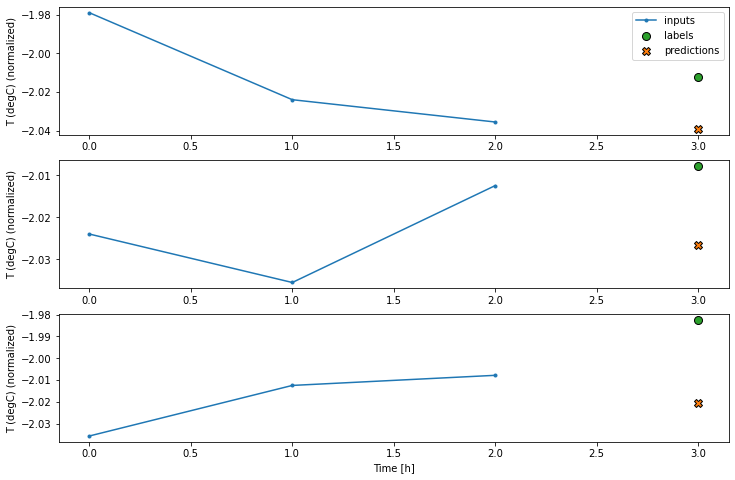

In [58]:
conv_step_train.plot(multi_step_dense)

# Recrrent Neural Networks

In [59]:
print('input shape', wide_step_train.example[0][0].shape)
print('output shape', wide_step_train.example[0][1].shape)

input shape torch.Size([1, 24, 19])
output shape torch.Size([1, 24, 1])


[Epoch 0/10]
 --------------------

 mean training loss 0.05987684151055473
 mean validation loss 0.0016489780480000234
[Epoch 1/10]
 --------------------

 mean training loss 0.0013680726716846332
 mean validation loss 0.0022770788262496578
[Epoch 2/10]
 --------------------

 mean training loss 0.0013955806805160808
 mean validation loss 0.001501613217263375
[Epoch 3/10]
 --------------------

 mean training loss 0.0012592154344101332
 mean validation loss 0.0011288739950755234
[Epoch 4/10]
 --------------------

 mean training loss 0.0010628695601023917
 mean validation loss 0.0017123075403147124
[Epoch 5/10]
 --------------------

 mean training loss 0.0009455353237576021
 mean validation loss 0.0009293510272192111
[Epoch 6/10]
 --------------------

 mean training loss 0.0008998839620622125
 mean validation loss 0.0009688832166008305
[Epoch 7/10]
 --------------------

 mean training loss 0.0008202602259423465
 mean validation loss 0.0012879379297967984
[Epoch 8/10]
 -------------

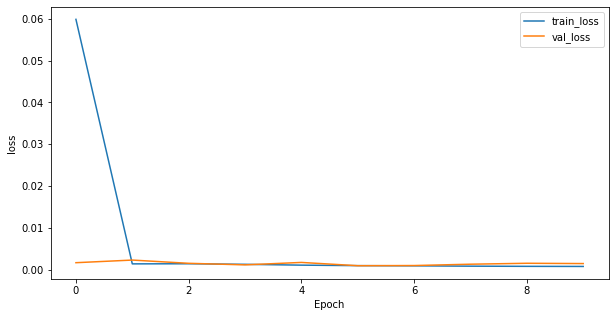

In [60]:
class LstmModel(nn.Module):
    def __init__(self):
        super().__init__()
        # (batch, time, featres) => (batch, time, lstm_units)
        self.lstm = nn.LSTM(input_size=19,
                            hidden_size=32).double()
        # (batch, time, lstm_units) => (batch, time, features)
        self.lin = nn.Linear(32, 1).double()
        
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = self.lin(x)
        
        return x
    
lstm_model = LstmModel()
lstm_model.to(DEVICE)
opt = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
train_dl, valid_dl = get_data(train_ds=wide_step_train, valid_ds=wide_step_val, bs=32)
loss_fn = nn.MSELoss()

# epochs, model, loss_func, opt, train_dl, valid_dl
history = fit(10, lstm_model, loss_fn, opt, train_dl, valid_dl)
history.plot()

LstmModel(
  (lstm): LSTM(19, 32)
  (lin): Linear(in_features=32, out_features=1, bias=True)
)
{'T (degC)': 0}


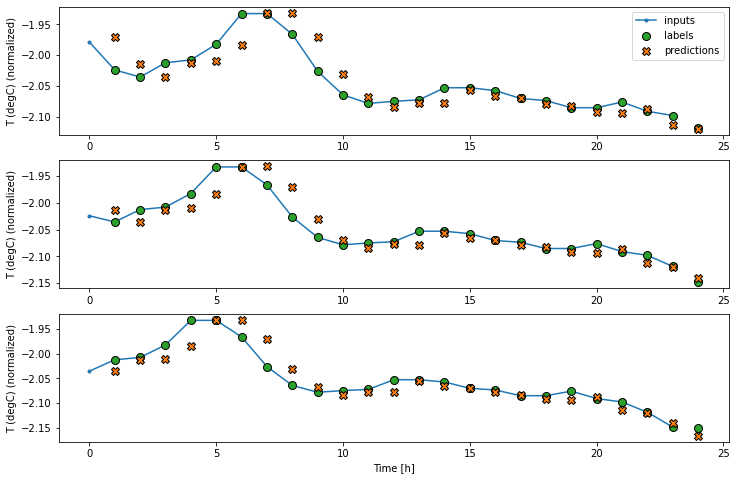

In [61]:
wide_step_train.plot(lstm_model)

LSTM이 학습에 시간을 가장 많이 소요하였지만 성능이 가장 좋게 나왔다.
Sequential 데이터를 다룰 때 LSTM을 사용하는 것이 좋다는 것을 알 수 있었다.

# Reference

https://www.kaggle.com/code/riyadhrazzaq/pytorch-jena-weather-time-series